In [1]:
import time
from timeit import timeit

from astropy import units as u
from poliastro.bodies import Sun, Moon, Earth

from CircularRestricted import *
%matplotlib inline

In [2]:
a_earth = 1.0 * u.au  # km - 1 AU

# Use Poliastro to get body masses: Earth, Moon
# Then instantiate the CR3BP using the Synodic (rotating) Barycentric reference frame
frame = CR3BP(Sun.mass, Earth.mass, a_earth)

mu = frame.mu
xL, yL = frame.xL['L1'], frame.yL['L1']
ac = frame.convert((0.26 * u.mm/(u.s**2)).to('km/s2'))
sc = Spacecraft(frame, ar=ac, at=ac)
sc.set_initial_state([sc.xL_aug-1e-6, 1e-6, 1e-6, 0, 0, 0])
K_xy  = 1
K_z   = 2
db_xy = 0.0003
db_z  = 0.003
sc.set_thrust_profile('sail_control', sc.xL_aug, K_xy, K_z, db_xy, db_z)

# print(sc.controller_params)
prop = Propagator(frame, sc, method='numbalsoda', )


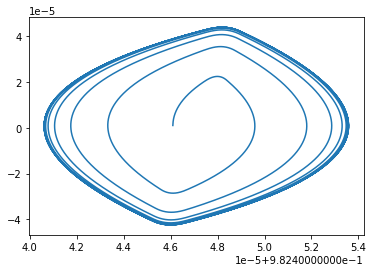

In [3]:
T, X = prop.integrate(2*np.pi)
plt.plot(X[0],X[1])
plt.show()

In [4]:
def num_sails(side_length, target_dist, percent_reduction=1.8):
    # Calculate subtended solid angle of the sun from the Earth
    R_sun = Sun.R.to('km').value
    D_sun = (1*u.au).to('km').value
    th_sun = np.arctan2(R_sun,D_sun)*u.rad
    sa_sun = 4*np.pi*np.sin(th_sun/2)**2 * u.sr
    # Calculate subtended solid angle of a single sail from the Earth
    R_sail = side_length.to('m')
    D_sail = target_dist.to('m')
    th_sail = np.arctan2(R_sail,D_sail)
    sa_sail = (th_sail**2).to('sr')
    # Determine number of sails needed to subtend a given amount 
    # (percent_reduction) of the sun's subtended area
    num_sails = int(np.ceil(((percent_reduction/100)/(sa_sail/sa_sun)).value))
    return "{:,} sailcraft".format(num_sails) + \
           " with %0.1f m^2 sail areas"%(side_length.to('m').value**2) + \
           " at a distance of {:,} km would be needed".format(
                np.round(target_dist.to('km').value)) + \
           " for a %0.2f%% reduction in solar irradiance"%(percent_reduction)

In [5]:
xL_aug_dist = frame.convert((1-frame.mu),to='m') - frame.convert(sc.xL_aug,to='m')
xL_dist = frame.convert((1-frame.mu),to='m') - frame.convert(frame.xL['L1'],to='m')
num_sails(100*u.m, xL_aug_dist)

'842,963,332 sailcraft with 10000.0 m^2 sail areas at a distance of 2,625,428.0 km would be needed for a 1.80% reduction in solar irradiance'

In [6]:
num_sails(20*u.m, xL_dist)

'6,801,813,474 sailcraft with 400.0 m^2 sail areas at a distance of 1,491,551.0 km would be needed for a 1.80% reduction in solar irradiance'

In [7]:
num_sails(20*u.m, xL_dist/3)

'755,757,053 sailcraft with 400.0 m^2 sail areas at a distance of 497,184.0 km would be needed for a 1.80% reduction in solar irradiance'

In [9]:
frame2 = CR3BP(Earth.mass, Moon.mass, 384400*u.km)

In [10]:
frame2.convert(frame2.xL['L2'],to='km')

<Quantity 444244.2230668 km>

In [11]:
x_tgt = ((1-frame.mu) - ((1-frame.mu)-frame.xL['L1'])/0.5).value
print('x_tgt:  ', x_tgt)
print('xL:     ', frame.xL['L1'])
print('xL_aug: ', sc.xL_aug)

x_tgt:   0.9800561918104004
xL:      0.9900265941650362
xL_aug:  0.9824470954938515


In [12]:
x_tgt=0.99
X0 = [x_tgt+10e-6, -10e-6, 0, 0, 0, 0]
sc.set_initial_state(X0)
K_xy  = 1000
K_z   = 1
db_xy = 0.0001
db_z  = 0.001
sc.set_thrust_profile('sail_control', x_tgt, K_xy, K_z, db_xy, db_z)
T, X = sc.propagate(prop,t_max=2*np.pi, n=1000)

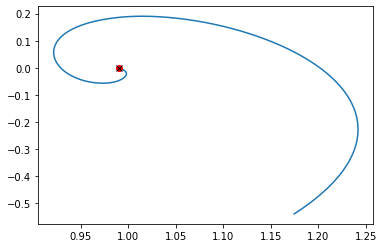

In [13]:
plt.plot(X[0],X[1])
plt.plot(X[0][0],X[1][0],'ro')
plt.plot(x_tgt,0,'kx')

In [14]:
ddX = CR3BP_EOM(frame.mu.value, np.array(X0,np.float64))
print(ddX)
print(ac)

[-0.00015116154933184848, 3.045789487363217e-05, -0.0]
0.0438441074732289


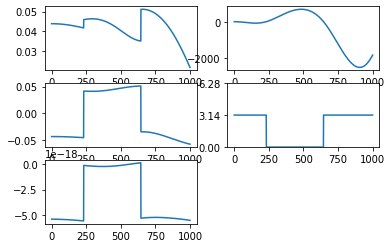

In [15]:
a_x, a_y, a_z, error, beta = sail_control_diagnostic(X, sc.ar, sc.at, x_tgt, K_xy, K_z, db_xy, db_z)
plt.subplot(321)
plt.plot(a_x)
plt.subplot(323)
plt.plot(a_y)
plt.subplot(325)
plt.plot(a_z)

plt.subplot(322)
plt.plot(error)
plt.subplot(324)
plt.plot(beta)
plt.ylim([0,2*np.pi])
plt.yticks([0,3.14,6.28]);

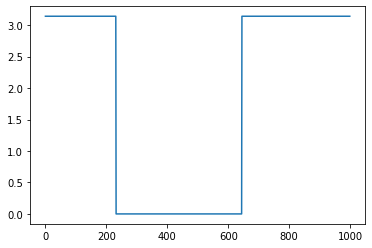

In [16]:
plt.plot(0.5*np.pi*(1 - np.tanh(1e5*error)))

In [140]:
periodic

<function CircularRestricted.core.periodic(mu, L_pt, eps0, zeta=0, d_eta0=None, aug=None, verbose=False)>